In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
BASE_DIR = '/content/drive/MyDrive/image_captioning/BASEdir'
WORKING_DIR = '/content/drive/MyDrive/image_captioning/workingdir'

In [5]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt


# Load the pretrained model
model_path = '/content/drive/MyDrive/image_captioning/workingdirbest_model.h5'
model = keras.models.load_model(model_path)
print('Model loaded successfully.')

# Load the features
features_path = '/content/drive/MyDrive/image_captioning/workingdir/features.pkl'
with open(features_path, 'rb') as f:
    features = pickle.load(f)
print('Features loaded successfully.')




Model loaded successfully.
Features loaded successfully.


In [6]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [7]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40460 [00:00<?, ?it/s]

In [8]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [9]:
clean(mapping)

In [10]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [12]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [13]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [14]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

553467096/553467096 [==============================] - 6s 0us/step


In [15]:
max_length = max(len(caption.split()) for caption in all_captions)

In [16]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
import os
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

#TO CAPTIONIZE A IMAGE ALREADY IN DATASET

---------------------Actual---------------------
startseq black dog leaps over log endseq
startseq grey dog is leaping over fallen tree endseq
startseq large black dog leaps fallen log endseq
startseq mottled black and grey dog in blue collar jumping over fallen tree endseq
startseq the black dog jumped the tree stump endseq
--------------------Predicted--------------------
startseq black dog mouth over teams in runs near endseq


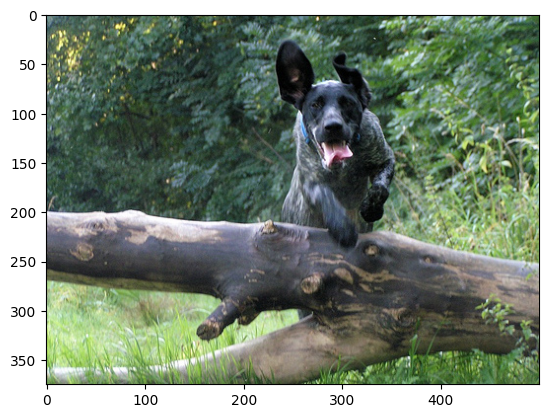

In [22]:
# Example function to generate caption
# Example usage
image_id = '1015584366_dfcec3c85a.jpg'  # Replace with an actual image ID from your dataset
generate_caption(image_id)
#print(f'Generated caption for {image_id}: {caption}')

#TO CAPTIONIZE A UNSEEN IMAGE

PREDICTION -> man is standing on hands wall


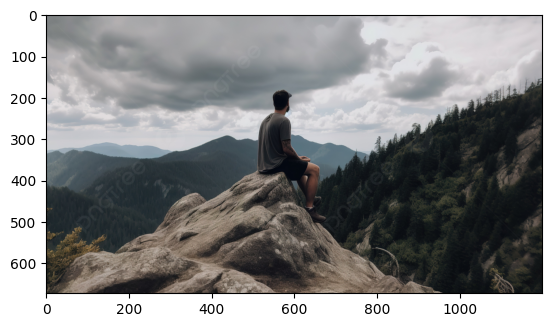

In [20]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/image_captioning/pngtree-man-sitting-on-a-rock-overlooking-mountains-and-clouds-picture-image_3137688.jpg'
# load image

image2 = Image.open(image_path)
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
out = (predict_caption(model, feature, tokenizer, max_length)).split()

out.pop(-1)
out.pop(0)
out = " ".join(out)
print(f"PREDICTION -> {out}")
plt.imshow(image2)